In [1]:
import pandas as pd
import segmentation_models_pytorch as smp
import pickle
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random

from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from torch.utils.data import ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import segmentation_models_pytorch as smp

from sklearn.model_selection import KFold, StratifiedKFold
from functools import partial
from typing import List, Optional, Callable

import os
import logging
os.chdir('../../')

from src.utils.util import get_labedict, visualize, \
                           color_mask, get_num2color
from src.utils.dataset import VOCDataset, VOC_ProbDataset
from src.utils.train import TrainEpoch, ValidEpoch
from src.utils.metrics import Multiclass_IoU_Dice
from src.utils.augmentation import get_training_augmentation, \
                                get_validation_augmentation, \
                                get_preaug, get_postaug, \
                                get_preprocessing
from src.utils.losses import DiceFocal                               
from src.utils.scheduler import PolyLR


In [2]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def get_logger():
    output_loc = os.path.join('./output')
    os.makedirs(output_loc, exist_ok=True)

    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)
    file_handler = logging.FileHandler(os.path.join(output_loc, 'train.log'))
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    return logger

def seed_all(seed):
    # https://discuss.pytorch.org/t/reproducibility-with-all-the-bells-and-whistles/81097
    if not seed:
        seed = 10
    print("[ Using Seed : ", seed, " ]")
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_vc_df(cur_train_df, col):
    cnt_vc = pd.DataFrame(cur_train_df[col].value_counts())
    cnt_vc = cnt_vc.reset_index()
    cnt_vc.columns = [col,'cnt']
    cnt_vc['weight'] = 1/np.log(cnt_vc.cnt)
    cnt_vc['weight'] = cnt_vc['weight'] / cnt_vc['weight'].sum()
    return cnt_vc

In [3]:
# get logger
logger = get_logger()

# set seed
seed = 2022
seed_all(seed)

# load data
labeldict = get_labedict()
label2num = labeldict['label2num']
num2label = labeldict['num2label']

train_df = pd.read_csv('./data/train_df.csv', index_col=0)
kf_cols =  [i for i in train_df.columns if i.startswith('kf')]
skf_cols =  [i for i in train_df.columns if i.startswith('skf')]

# get congigs
IMBALANCE = True
SPLIT = 'random'
RESAMPLING_STRATEGY = 'x2'
COPYPASTE = True
SPLIT_RS = 1
SPLIT_FNUM = 0

LR = 0.1
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'
VERBOSE = True
PASTE_BY = 'cnt' # cnt, performance

copypaste_prop = None if COPYPASTE == False else 1.0

# determine paste classes and its probability by cnt_df
if PASTE_BY == 'cnt':
    cnt_df = pd.read_csv('./data/imbalance_df.csv', index_col=0)    
    paste_dict = dict(cnt_df[cnt_df['after'] < 60]['after'].apply(lambda x: int(100/x) ))
    paste_list = []
    for label, num in paste_dict.items():
        paste_list += [label]*num
# determine paste classes by segmentation performance
# ref: https://www.researchgate.net/figure/Evaluation-results-of-the-PASCAL-VOC-2012-test-set_tbl1_315635038
elif PASTE_BY == 'performance':
    result_df = pd.read_csv('./data/previous_results.csv', index_col=0)
    paste_list = list(result_df.mean(axis=1).sort_values()[:8].index)
else:
    paste_list = None

if IMBALANCE:
    print(f'before imbalance {len(train_df)}')
    train_df = train_df[train_df['use_image']==True]
    print(f'after imbalance {len(train_df)}')

cur_split = f'{SPLIT}_rstate{SPLIT_RS}_fold{SPLIT_FNUM}'
cur_train_df = train_df[train_df[cur_split] == 'train']
cur_val_df = train_df[train_df[cur_split] == 'val']

if RESAMPLING_STRATEGY == 'x2':
    vc_col = None
    vc_df = None
elif RESAMPLING_STRATEGY == 'cluster':
    vc_col = 'cluster_num_16'
    vc_df = get_vc_df(cur_train_df, vc_col)
elif RESAMPLING_STRATEGY == 'cnt':
    vc_col = 'major_label'
    vc_df = get_vc_df(cur_train_df, vc_col)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


[ Using Seed :  2022  ]
before imbalance 1464
after imbalance 993


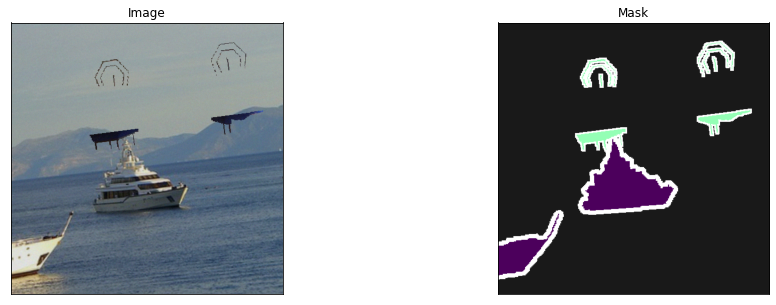

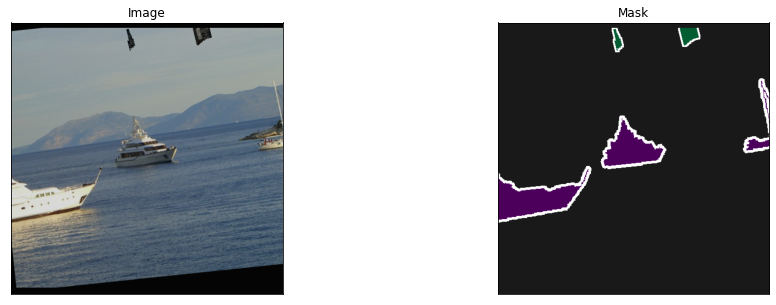

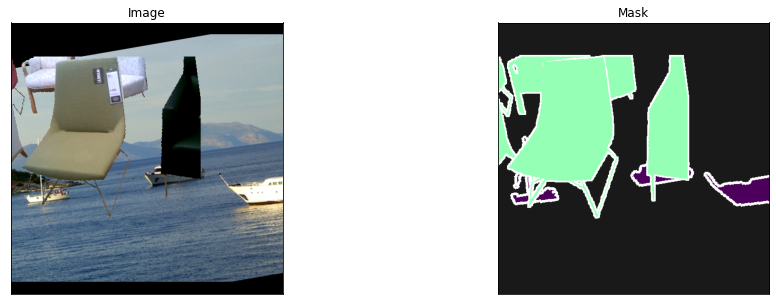

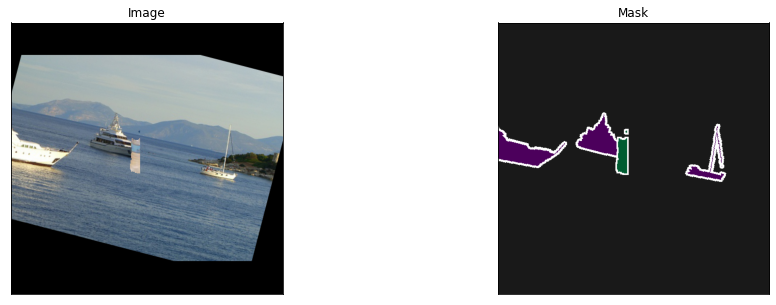

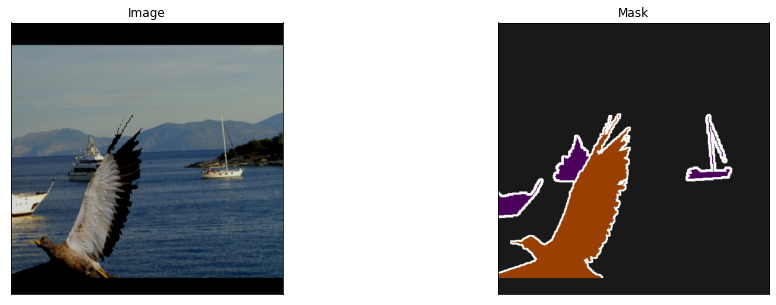

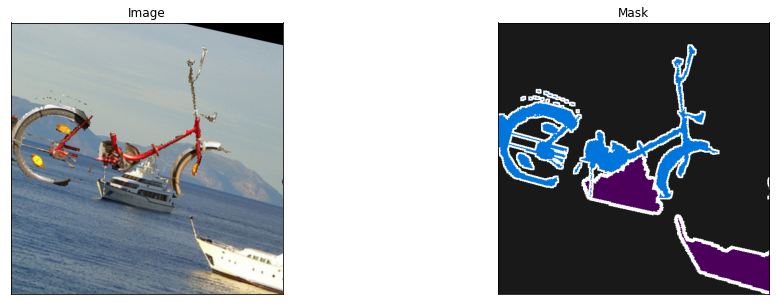

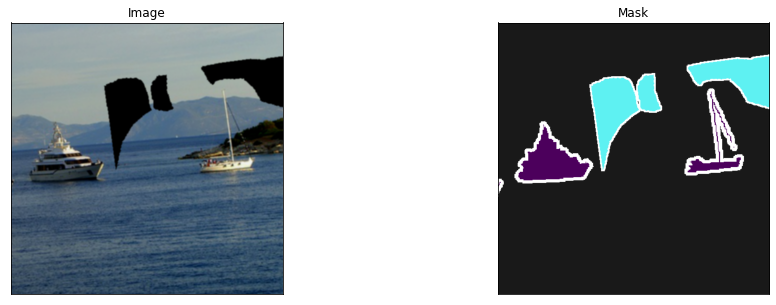

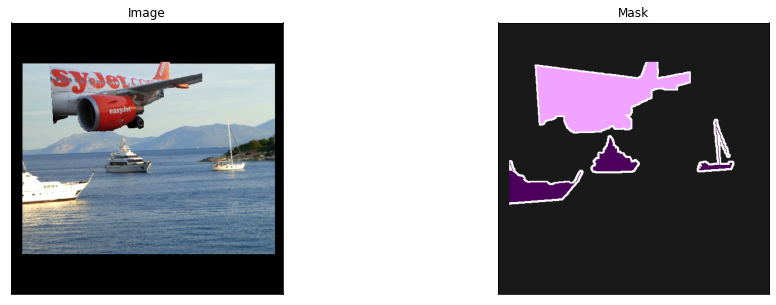

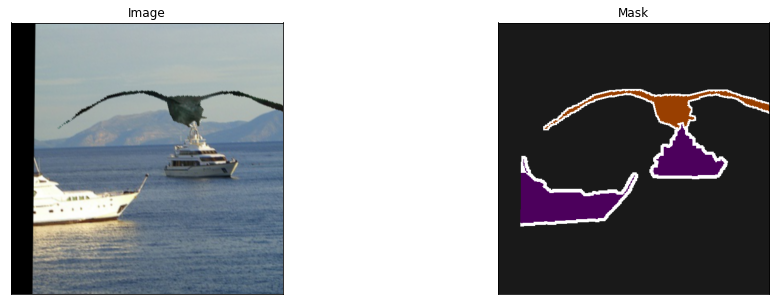

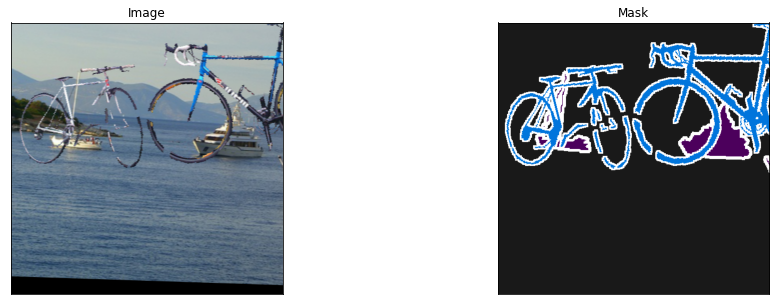

In [4]:
num2color = get_num2color(num2label)

dataset_a = VOC_ProbDataset(cur_train_df,
                            augmentation=get_training_augmentation(),
                            # preprocessing=get_preprocessing(preprocessing_fn),
                            copypaste_prop = copypaste_prop,
                            paste_list=paste_list,
                            pre_aug=get_preaug,
                            post_aug=get_postaug(),
                            label2num=label2num,)

dataset_b = VOC_ProbDataset(cur_train_df,
                            augmentation=get_training_augmentation(),
                            # preprocessing=get_preprocessing(preprocessing_fn),
                            copypaste_prop = copypaste_prop,
                            paste_list=paste_list,
                            pre_aug=get_preaug,
                            post_aug=get_postaug(),
                            label2num=label2num,
                            vc_col=vc_col,
                            vc_df=vc_df)

train_dataset = ConcatDataset([dataset_a, dataset_b])

valid_dataset = VOCDataset(
    cur_val_df,
    augmentation=get_validation_augmentation(), 
    #preprocessing=get_preprocessing(preprocessing_fn),
)

# same image with different random transforms
for i in range(10):
    image, mask, _ = train_dataset[3]
    visualize(num2color, image=image, mask=mask)
    

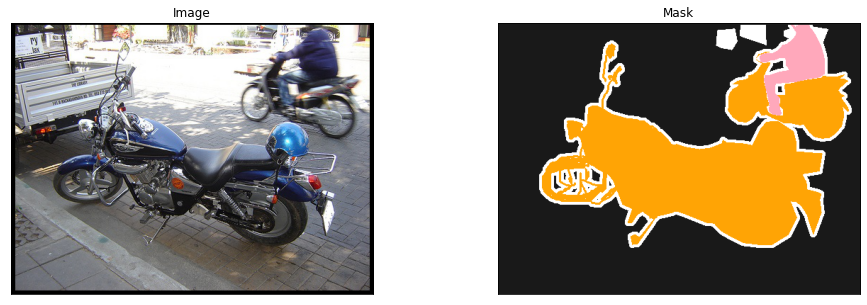

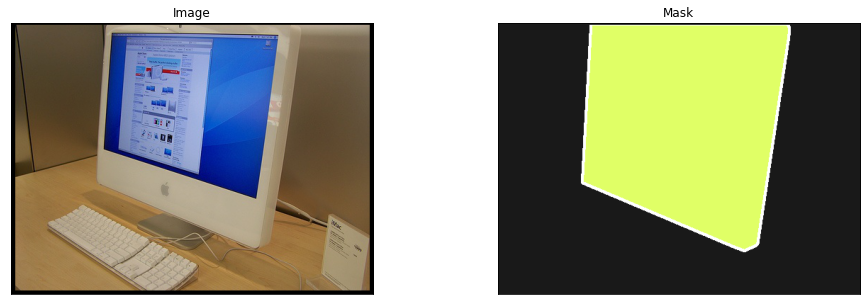

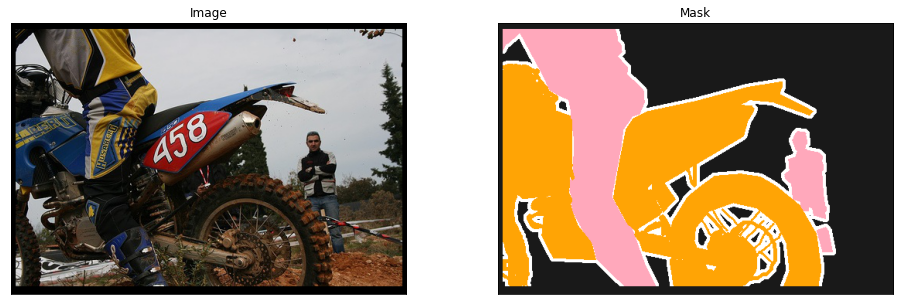

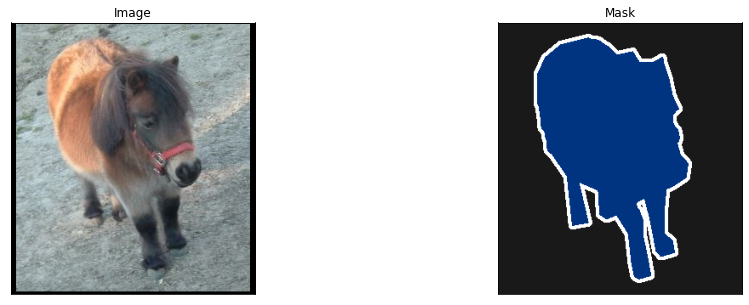

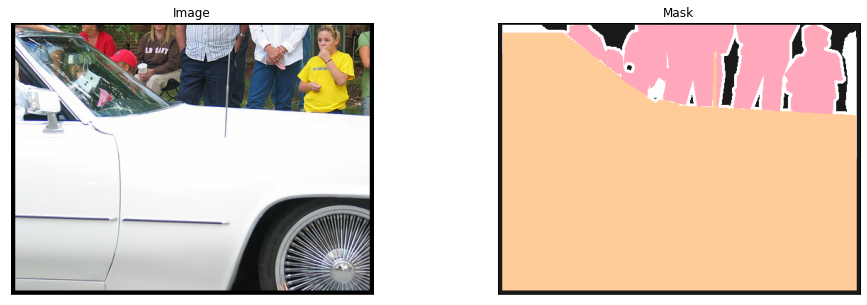

In [5]:
for i in range(5):
    image, mask, _ = valid_dataset[i]
    visualize(num2color, image=image, mask=mask)

In [6]:
dataset_a = VOC_ProbDataset(cur_train_df,
                            augmentation=get_training_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn),
                            copypaste_prop = copypaste_prop,
                            paste_list=paste_list,
                            pre_aug=get_preaug,
                            post_aug=get_postaug(),
                            label2num=label2num,)

dataset_b = VOC_ProbDataset(cur_train_df,
                            augmentation=get_training_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn),
                            copypaste_prop = copypaste_prop,
                            paste_list=paste_list,
                            pre_aug=get_preaug,
                            post_aug=get_postaug(),
                            label2num=label2num,
                            vc_col=vc_col,
                            vc_df=vc_df)

train_dataset = ConcatDataset([dataset_a, dataset_b])

valid_dataset = VOCDataset(
    cur_val_df,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0,
                        worker_init_fn= seed_worker)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

label_names = label2num.keys()

weight_decay = 1e-4

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(label_names), 
    activation='softmax2d',
)

classes_of_interest = [label2num[k] for k in label2num.keys() \
                    if k not in ['border']] 

# loss = smp.losses.DiceLoss(mode = 'multiclass', 
#                            from_logits = False,
#                            ignore_index = label2num['border'])
# setattr(loss, '__name__', 'dice_loss')

dice = smp.losses.DiceLoss(mode = 'multiclass', 
                           from_logits = False,
                           ignore_index = label2num['border'])
focal = smp.losses.FocalLoss(mode = 'multiclass', 
                             ignore_index = label2num['border'])

loss = DiceFocal(dice, focal)
loss_name = 'loss'
metric_name = 'm_iou'
loss_names = ['loss', 'dice_loss', 'focal_loss']





In [7]:



metrics = [
    Multiclass_IoU_Dice(mean_score=True,
                        nan_score_on_empty=True,
                        classes_of_interest = classes_of_interest,
                        name=metric_name)
]

# optimizer = torch.optim.Adam([ 
#     dict(params=model.parameters(), lr=0.01),
# ])
optimizer = torch.optim.SGD(params=[
        {'params': model.encoder.parameters(), 'lr': 0.1 * LR},
        {'params': model.decoder.parameters(), 'lr': LR},
        {'params': model.segmentation_head.parameters(), 'lr': LR},
    ], lr=LR, momentum=0.9, weight_decay=weight_decay)

# scheduler = ReduceLROnPlateau(optimizer, 'max', patience=7)
num_epoch = 2
batch_size= 4
device = "cuda"
verbose = True

class_metrics = Multiclass_IoU_Dice(
        mean_score=False,
        nan_score_on_empty=True,
        classes_of_interest=classes_of_interest,
        name=metric_name,
        class_names= [num2label[i] for i in classes_of_interest] # label_names without borders
    )

scheduler = PolyLR(optimizer, int(num_epoch * len(train_dataset) / batch_size))
train_epoch = TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    verbose=verbose,
    loss_names=loss_names,
    class_metrics=class_metrics
)
valid_epoch = ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=verbose,
    loss_names=loss_names,
    class_metrics=class_metrics
)

max_score = 0


In [9]:

# logger.info('Train Started')
for i in range(1, 2): 
    # logger.info('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    # logger.info(f"train loss:{train_logs[f'{loss_name}']:.4f}, train iou:{train_logs[f'{metric_name}']:.4f}")
    valid_logs = valid_epoch.run(valid_loader)
    # logger.info(f"valid loss:{valid_logs[f'{loss_name}']:.4f}, valid iou:{valid_logs[f'{metric_name}']:.3f}")

    if (max_score < valid_logs[f'{metric_name}']) and (i > 50):
        max_score = valid_logs[f'{metric_name}']
        # torch.save(model.state_dict(), './best_model.pt')
        # logger.info('Model saved!')
    scheduler.step(valid_logs[f'{metric_name}'])
    
    

train: 100%|█| 201/201 [03:4
valid: 100%|█| 192/192 [00:0


/home/nys/anaconda3/envs/my_env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [11]:
print(train_logs)

{'m_iou': 0.35639671767317377, 'loss': 4.243607935027698, 'dice_loss': 0.42728766254079886, 'focal_loss': 3.8163202757859116, 'aeroplane': 0.14849413645613427, 'bicycle': 0.09062727136519416, 'bird': 0.07103752465918017, 'boat': 0.0, 'bottle': 0.3213471953149727, 'bus': 0.24924330372876852, 'car': 0.12915794817684834, 'cat': 0.43336425819638785, 'chair': 0.0, 'cow': 0.0, 'diningtable': 0.0, 'dog': 0.37884201952086344, 'horse': 0.0, 'motorbike': 0.20957896600864742, 'person': 0.34254633357591985, 'pottedplant': 0.0, 'sheep': 0.05085908825615416, 'sofa': 0.0, 'train': 0.238577769149964, 'tvmonitor': 0.0, 'background': 0.7511014529585365}


In [13]:
from tqdm import tqdm

In [ ]:
test_df = pd.read_csv('./data/test_df.csv', index_col=0)
# best_model = smp.DeepLabV3Plus(
#     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=len(label_names), 
#     activation='softmax2d',
# )
# best_model.load_state_dict(torch.load('./best_model.pt'))
best_model = model
test_dataset = VOCDataset(
    test_df,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

test_metric = Multiclass_IoU_Dice(mean_score=False,
                                    nan_score_on_empty=True,
                                    classes_of_interest = classes_of_interest,
                                    name=metric_name)

results = {}
best_model.to(DEVICE)
test_metric.to(DEVICE)
best_model.eval()
for x, y_true, img_id in tqdm(test_loader):
    x, y_true = x.to(DEVICE), y_true.to(DEVICE)
    with torch.no_grad():
        y_pred = best_model.forward(x)
    result = test_metric(y_pred, y_true)
    results[img_id[0]] = result[0]

result_df = pd.DataFrame.from_dict(results, orient='index')
result_df.columns = [num2label[num] for num in classes_of_interest]

class_result = result_df.apply(lambda x: np.nanmean(x))
print(class_result)
print('MIOU: ',np.mean(class_result))

100%|▉| 1443/1449 [00:46<00: